In [2]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

INPUT_DIRECTORY = "../input/3d-contour-formation-dataset/"

In [3]:
class Face:
    def __init__(self, image):
        self.image = image
        
    def get_contour(self, draw=False):
        imgray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        contours, hierarchy = cv2.findContours(imgray, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        contour = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)[0]
        self.contour = [point[0] for point in contour]
        
        if draw:
            cv2.drawContours(self.image, [contour], -1, (255, 0, 0), 10)
            plt.imshow(self.image)
    
    def translate(self):
        xs, ys = [], []
        for x, y in self.contour:
            xs.append(x), ys.append(y)
        min_x, min_y = min(xs), min(ys)
        for i in range(len(self.contour)):
            self.contour[i][0] -= min_x
            self.contour[i][1] -= min_y
        
    def transform(self, axis, k):
        xs, ys, zs = [], [], []
        for point in self.contour:
            a, b = point[0], point[1]
            if axis == 0:
                xs.append(k), ys.append(a), zs.append(b)
            elif axis == 1:
                xs.append(a), ys.append(k), zs.append(b)
            elif axis == 2:                        
                xs.append(a), ys.append(b), zs.append(k)
        self.xs = xs
        self.ys = ys
        self.zs = zs
        
def show_contours(x, y, z):
    fig = plt.figure()
    axis = fig.add_subplot(projection='3d')
    axis.set_xlabel('X Label')
    axis.set_ylabel('Y Label')
    axis.set_zlabel('Z Label')
    axis.scatter(x, y, z)
    
def merge_contours(objects):
    xs, ys, zs = [], [], []
    for obj in objects:
        xs += obj.xs
        ys += obj.ys
        zs += obj.zs
    return xs, ys, zs

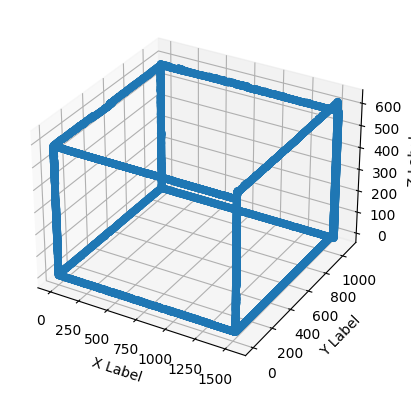

In [4]:
filepaths = [os.path.join(INPUT_DIRECTORY, file) for file in os.listdir(INPUT_DIRECTORY)]

filepaths.sort()

images = [cv2.imread(path) for path in filepaths]

obj1 = Face(images[0])
obj1.get_contour()
obj1.translate()
obj1.transform(0, 0)

obj2 = Face(images[1])
obj2.get_contour()
obj2.translate()
obj2.transform(1, 0)

x_trans = max(obj2.xs)
y_trans = max(obj1.ys)

obj3 = Face(images[2])
obj3.get_contour()
obj3.translate()
obj3.transform(0, x_trans)

obj4 = Face(images[3])
obj4.get_contour()
obj4.translate()
obj4.transform(1, y_trans)

xs, ys, zs = merge_contours([obj1, obj2, obj3, obj4])
show_contours(xs, ys, zs)

In [5]:
# Box: 11.75 x 17 x 6.4 cm

xs, ys = [], []
for x, y in obj1.contour:
    xs.append(x), ys.append(y)

max_x, max_y = max(xs), max(ys)
min_x, min_y = min(xs), min(ys)
x_ratio = (max_x - min_x) / 11.75
y_ratio = (max_y - min_y) / 6.4

zs = [z for z, _ in obj2.contour]
z_ratio = (max(zs) - min(zs)) / 17

print("Pixel to Centimeter Ratios :-")
print("X Ratio", x_ratio)
print("Y Ratio", y_ratio)
print("Z Ratio", z_ratio)

Pixel to Centimeter Ratios :-
X Ratio 89.27659574468085
Y Ratio 91.40625
Z Ratio 89.41176470588235


In [10]:
!pip install transformers --upgrade
from transformers import pipeline
from PIL import Image
import requests

pipe = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-small-hf")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


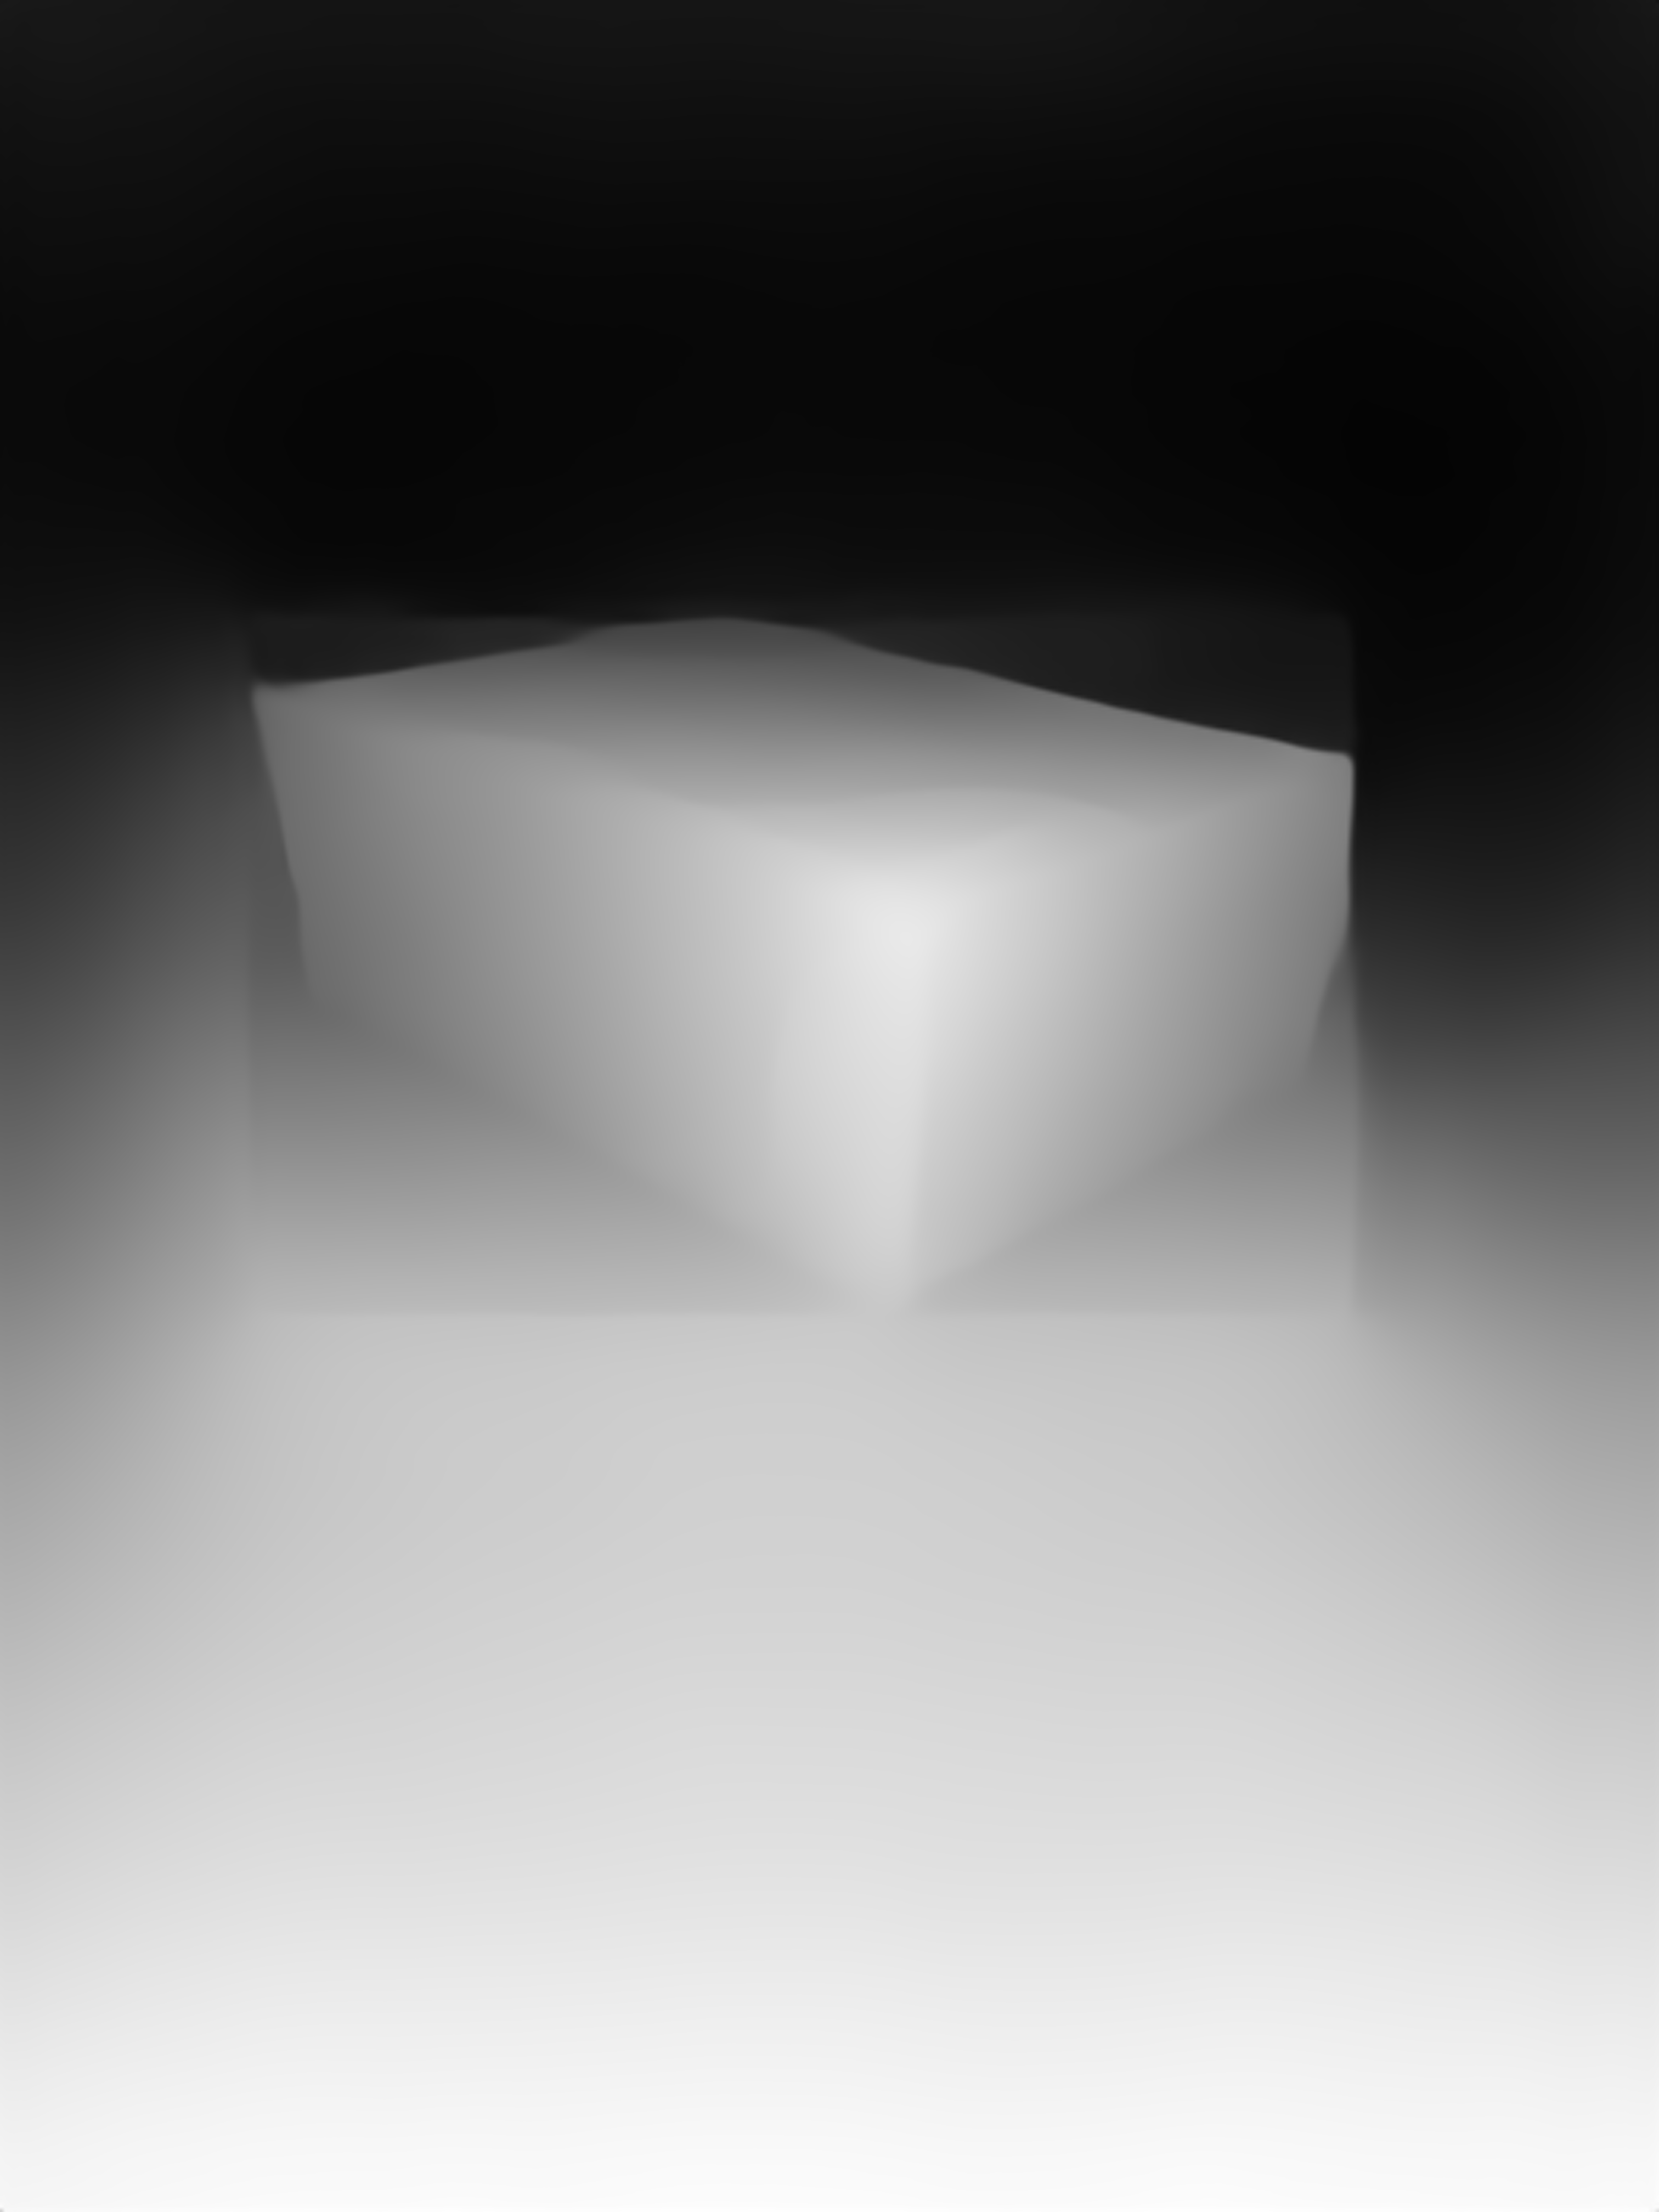

In [11]:
filepaths = [os.path.join(INPUT_DIRECTORY, file) for file in os.listdir(INPUT_DIRECTORY)]
image = Image.open(filepaths[2])
depth = pipe(image)["depth"]
depth